# Simulation of a Kerr-Black-Hole
by **Florian Hollants**

This Jupyter Notebook simulates a rotating Black Hole in SageMath using the Kerr Metric. The Project is based on the work of Florentin Jaffredo. The parameters for mass and angular momentum can be altered in Cell 5 by changing "m_val" and "a_val", while the "Angle" can be changed in Cell 18. 

In [1]:
# n_cpu = 4 # 4 Go Ram minimum
# n_geod = 100
# nx, ny = 180, 90

In [2]:
n_cpu = 8 # 8 Go Ram minimum
n_geod = 1000
nx, ny = 720, 360

In [3]:
# n_cpu = 36 # 144 Go Ram minimum
# n_geod = 30000
# nx, ny = 4000, 2000

In [4]:
%display latex

In [5]:
M = Manifold(4, 'M', structure='Lorentzian')

m = var('m')
a = var('a')

m_val = 2
a_val = 1

C.<t, r, th, ph> = M.chart(r't r:(4.2,+oo) th:(0,pi):\theta ph:\phi') #check that minimum radius is bigger than singularity in g[1,1]
C.coord_range()

t: (-oo, +oo); r: (4.20000000000000, +oo); th: (0, pi); ph: (-oo, +oo)

In [6]:
g = M.metric()
g[0,0] = (2*m*r)/(r^2+(a*cos(th))^2)-1
g[0,3] = -2*m*r*a*sin(th)^2/(r^2+(a*cos(th))^2)
g[1,1] = (r^2+(a*cos(th))^2)/(r^2-2*m*r+a^2)
g[2,2] = r^2+(a*cos(th))^2
g[3,3] = (r^2+a^2+(2*m*r*a^2*sin(th)^2)/(r^2+(a*cos(th))^2))*sin(th)^2
g[:]

[                                  2*m*r/(a^2*cos(th)^2 + r^2) - 1                                                                 0                                                                 0                          -2*a*m*r*sin(th)^2/(a^2*cos(th)^2 + r^2)]
[                                                                0                         (a^2*cos(th)^2 + r^2)/(a^2 - 2*m*r + r^2)                                                                 0                                                                 0]
[                                                                0                                                                 0                                               a^2*cos(th)^2 + r^2                                                                 0]
[                         -2*a*m*r*sin(th)^2/(a^2*cos(th)^2 + r^2)                                                                 0                                                                 0 (2*a^2*m*r*sin(th)^2/(a^2*cos(th)^2 + r^2) + a^2 + r^2)*sin(th)^2]

In [7]:
E.<x, y, z> = EuclideanSpace()
phi = M.diff_map(E, [r*sin(th)*cos(ph), r*sin(th)*sin(ph), r*cos(th)])
phi.display()

M --> E^3
   (t, r, th, ph) |--> (x, y, z) = (r*cos(ph)*sin(th), r*sin(ph)*sin(th), r*cos(th))

## One Geodesic

Try the following for circular Orbit

In [8]:
p = M((0, 14.98, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((2, 0, 0.005, 0.05))
v = v / sqrt(-g.at(p)(v, v))

tau = var('tau')

curve = M.integrated_geodesic(g, (tau, 0, 5000), v)
sol = curve.solve(step = 1, method="ode_int", parameters_values={m: m_val, a: a_val})

interp = curve.interpolate()

P = curve.plot_integrated(mapping=phi, color="red", thickness=2, plot_points=5000)
P += sage.plot.plot3d.shapes.Sphere(4, color='grey')
P

Graphics3d Object

Try the following for light at different Values for a, aimed directly at the Black Hole

In [9]:
# p = M((0, 20, pi/2, 0))
# Tp = M.tangent_space(p)
# v = Tp((2, -1, 0.000, 0.00))
# v = v / sqrt(-g.at(p)(v, v))

# A=[0,1,2,4] #list of values for a
# Color=[["red"], ["blue"], ["green"],["orange"], ["black"]] #color for different Geodesics

# P = sage.plot.plot3d.shapes.Sphere(4, color='grey')

# tau = var('tau')
# for i in range(4):
#     curve = M.integrated_geodesic(g, (tau, 0, 200), initial_tangent_vector=v, across_charts=True)
#     curve.solve_across_charts(step=0.2, parameters_values={m:m_val, a:A[i]})
#     interp = curve.interpolate()
#     P += curve.plot_integrated(mapping=phi, color=Color[i], thickness=2, plot_points=10000, across_charts=True)

# P

## Multiple Geodesics

In [10]:
import multiprocessing
from ipywidgets import FloatProgress
from IPython.display import display

In [11]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

n_batches_per_cpu = 3

In [12]:
curve = M.integrated_geodesic(g, (tau, 0, 200), v, across_charts=True)

In [13]:
args = []
start_index = 0

for chunk in chunks(range(n_geod), n_geod//(n_batches_per_cpu*n_cpu)):
    args += [(loads(curve.dumps()), start_index, len(chunk))] #
    start_index += len(chunk)

In [14]:
dt, y, r0 = var('dt, y, r0')

p = M((0, r0, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((dt, -1, 0, y))

sol = g.at(p)(v, v).solve(dt)
sol

[dt == (2*(a^3*m - 2*a*m^2*r0 + a*m*r0^2)*y - sqrt(-2*a^2*m*r0 - 4*m*r0^3 + r0^4 + (a^2 + 4*m^2)*r0^2 + (a^6 - 6*a^4*m*r0 - 6*m*r0^5 + r0^6 + 3*(a^2 + 4*m^2)*r0^4 - 4*(3*a^2*m + 2*m^3)*r0^3 + 3*(a^4 + 4*a^2*m^2)*r0^2)*y^2)*r0)/(2*a^2*m + 4*m*r0^2 - r0^3 - (a^2 + 4*m^2)*r0), dt == (2*(a^3*m - 2*a*m^2*r0 + a*m*r0^2)*y + sqrt(-2*a^2*m*r0 - 4*m*r0^3 + r0^4 + (a^2 + 4*m^2)*r0^2 + (a^6 - 6*a^4*m*r0 - 6*m*r0^5 + r0^6 + 3*(a^2 + 4*m^2)*r0^4 - 4*(3*a^2*m + 2*m^3)*r0^3 + 3*(a^4 + 4*a^2*m^2)*r0^2)*y^2)*r0)/(2*a^2*m + 4*m*r0^2 - r0^3 - (a^2 + 4*m^2)*r0)]

In [15]:
def calc_some_geodesics(args):
    """
    Compute nb geodesics starting at index n0
    """
    curve, n0, nb = args
    res = {}
    r = 100
    posi = [0, r, pi/2, 0]
    p = M(posi)
    Tp = M.tangent_space(p)
    for i in range(n0, n0+nb):
        dy = i*0.006/n_geod
        v = Tp([sol[0].rhs()(r0=r, y=dy, m=m_val, a=a_val).n(), -1, 0, dy])
        curve._initial_tangent_vector = v
        curve.solve_across_charts(step=0.2, parameters_values={m:m_val, a:a_val})
        res[i] = (p.coord(), curve._solutions.copy())
        curve._solutions.clear()
    return res

In [16]:
geo = {}
pool = multiprocessing.Pool(n_cpu)

%display plain
f = FloatProgress(min=0, max=n_geod)
display(f)

for i, some_res in enumerate(pool.map(calc_some_geodesics, args)):
    f.value += len(some_res)
    geo.update(some_res)

pool.close()
pool.join()

FloatProgress(value=0.0, max=1000.0)

In [17]:
P = sage.plot.plot3d.shapes.Sphere(4, color='grey')

for i in range(0, n_geod, 5*n_geod/100):    
    curve._solutions = geo[i][1]
    interp = curve.interpolate()
    P += curve.plot_integrated(mapping=phi, color=["red"], thickness=2, plot_points=150, 
                               label_axes=False, across_charts=True)#

P

Graphics3d Object

In [18]:
Angle = pi/20 #angle used in the actual calculation

Xi=a_val/m_val
Z_1=1+(1-Xi^2)^(1/3)*((1+Xi)^(1/3)+(1-Xi)^(1/3))
Z_2=(3*Xi^2+Z_1^2)^(1/2)
#calculating ISCO

disk_min = m_val*(3+Z_2-((3-Z_1)*(3+Z_1+2*Z_2))^(1/2))
print(numerical_approx(disk_min))
if disk_min<2*m_val:
    disk_min=2*m_val

disk_max = (50^2+disk_min^2-12^2)^(1/2)
#disk_max =25
#keeping area of accretion Disk the same as in original work of Florentin Jaffredo

#disk_min = 4
#disk_max = 50
alpha = -pi/20


8.46600505906165


In [19]:
D = sage.plot.plot3d.shapes.Torus((disk_min+disk_max)/2,
                                  (disk_max-disk_min)/2).scale(1,1,0.01).rotateY(-pi/20)

P + D

Graphics3d Object

In [20]:
P + D.rotateX(pi/3)

Graphics3d Object

In [21]:
#now begins the part where we calculate intersection with accretion disk and visualize the image
geo = [list(geo[i][1].values())[0][0][1].tolist() for i in range(len(geo))]

In [22]:
def intersection(curve, alpha, beta):
    """
    Return True if the curve intersect the disk comprised between dmin and dmax
    tilted of angles alpha and beta
    """
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):
        # done in 3 lines for speed consideration
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # conversion to cartesian:
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta) 
        # rotation around the X-axis:
        y2, z2 = y2*cos(beta)-z2*sin(beta), z2*cos(beta)+y2*sin(beta)  
        # rotation around the Y-axis:
        x2, z2 = x2*cos(alpha)-z2*sin(alpha), z2*cos(alpha)+x2*sin(alpha)       
        if z!=z2:           # needed to prevent a division by zero next line
            t = z/(z-z2)    # if 0<=t<1 then the curve intersect the disk between the points i and i-1
            if t>=0 and t<1 and curve[i][2]>disk_min and curve[i][2]<disk_max: #check coordinates
                return True
        x, y, z = x2, y2, z2
    return False

In [23]:
%time intersection(geo[28], alpha=pi/5, beta=0)

CPU times: user 1.7 s, sys: 15 ms, total: 1.72 s
Wall time: 1.71 s


False

In [24]:
%%cython
from libc.math cimport cos, sin
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef intersection(list curve, float alpha, float beta, float dmin, float dmax):
    """
    Return True if the curve intersect the disk comprised between dmin and dmax
    tilted of angles alpha and beta
    """
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                return True
        x, y, z = x2, y2, z2
    return False

In [25]:
%time intersection(geo[28], pi/5, 0, disk_min, disk_max)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 389 µs


False

In [26]:
import numpy as np
data = np.zeros( (ny, nx, 3), dtype=float )

In [27]:
def render_row(x):
    """
    Render a single row of the image
    """
    res = np.zeros((ny,3))                  # result row in RGB format
    for y in range(ny):                     # for each pixel in the row
        beta = atan2(y-ny/2,x)              # beta angle 
        r = sqrt(x**2+(y-ny/2)**2)          # pixel distance to the center of the image
        ind_geo = int(r/400*n_geod*720/nx)  # index of the geodesic to use. values are obtained by trial and error.
        if ind_geo<n_geod:                  # don't bother if the index is too big.
            if intersection(geo[ind_geo], float(Angle), float(beta), ###
                            float(disk_min), float(disk_max)):
                res[ny-1-y,:] = [255, 0, 0] # red if intersects; black otherwise
    return x, res                           # also return the argument, which is not remembered otherwise

In [28]:
def render():
    # display progress bar
    f = FloatProgress(min=0, max=nx)
    display(f)
    pool = multiprocessing.Pool(n_cpu, maxtasksperchild=int(10))
    for i, rows in enumerate(pool.map(render_row, range(-nx/2, nx/2))): # do and wait
        # update progress bar
        f.value+=1
        # copy the result in the right place
        x, res = rows
        data[:, x-nx/2, :] = res 
    # clean exit
    pool.close()
    pool.join()

In [29]:
render()

FloatProgress(value=0.0, max=720.0)

In [30]:
from PIL import Image

_errstr = "Mode is unknown or incompatible with input array shape."

def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tobytes())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tobytes())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tobytes())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tobytes())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tobytes())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tobytes())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tobytes()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tobytes()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tobytes()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

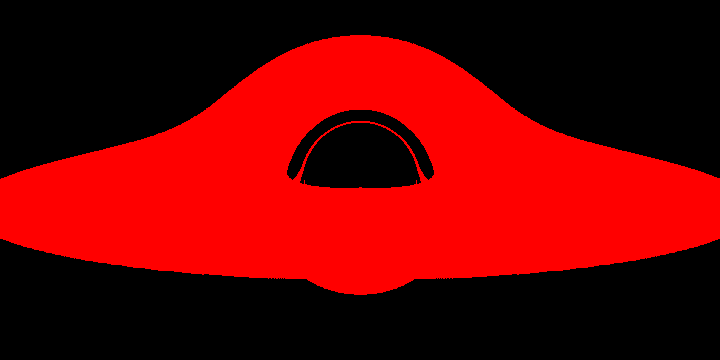

In [31]:
img1 = toimage(data)
img1

In [32]:
%display latex
g[:]

[                                  2*m*r/(a^2*cos(th)^2 + r^2) - 1                                                                 0                                                                 0                          -2*a*m*r*sin(th)^2/(a^2*cos(th)^2 + r^2)]
[                                                                0                         (a^2*cos(th)^2 + r^2)/(a^2 - 2*m*r + r^2)                                                                 0                                                                 0]
[                                                                0                                                                 0                                               a^2*cos(th)^2 + r^2                                                                 0]
[                         -2*a*m*r*sin(th)^2/(a^2*cos(th)^2 + r^2)                                                                 0                                                                 0 (2*a^2*m*r*sin(th)^2/(a^2*cos(th)^2 + r^2) + a^2 + r^2)*sin(th)^2]

In [33]:
r0, phi = var('r_0, phi')
p = M((0, r0, pi/2, phi))
g.at(p)[:]

[                (2*m - r_0)/r_0                               0                               0                      -2*a*m/r_0]
[                              0   r_0^2/(a^2 - 2*m*r_0 + r_0^2)                               0                               0]
[                              0                               0                           r_0^2                               0]
[                     -2*a*m/r_0                               0                               0 (2*a^2*m + a^2*r_0 + r_0^3)/r_0]

In [34]:
# default frame
fr = C.frame()

# create an automorphism field
aut = M.automorphism_field()

# some symbolic variables
a, b, c = var('a, b, c')

# let's try with the simplest matrix possible
aut.add_comp()[:] = [[a, 0, 0, 0], [b, c, 0, 0], [0, 0, 1/r0, 0], 
                     [0, 0, 0, 1/r0]] # only b is off-diagonal
fr2 = fr.new_frame(aut, 'f2')

In [35]:
g.at(p)[fr2.at(p), :]

[b^2*r_0^2/(a^2 - 2*m*r_0 + r_0^2) + a^2*(2*m - r_0)/r_0                       b*c*r_0^2/(a^2 - 2*m*r_0 + r_0^2)                                                       0                                          -2*a^2*m/r_0^2]
[                      b*c*r_0^2/(a^2 - 2*m*r_0 + r_0^2)                       c^2*r_0^2/(a^2 - 2*m*r_0 + r_0^2)                                                       0                                                       0]
[                                                      0                                                       0                                                       1                                                       0]
[                                         -2*a^2*m/r_0^2                                                       0                                                       0                       (2*a^2*m + a^2*r_0 + r_0^3)/r_0^3]

In [36]:
c = sqrt(r/(r+2*m))
a = sqrt(((r+2*m)/(r)))
b = -2*a*m/(2*m+r)

In [37]:
aut2 = M.automorphism_field() # new automorphism field
aut2.add_comp()[:] = [[a, 0, 0, 0], [b, c, 0, 0], [0, 0, 1/r, 0], [0, 0, 0, 1/(r*sin(th))]]
fr3 = fr.new_frame(aut2, 'f3')

In [38]:
g[fr3, :]

[(4*a^4*m^2*cos(th)^4 + 8*a^2*m^3*r - 2*a^2*m*r^3 - r^6 - (a^2 - 12*m^2)*r^4 + 4*(a^2*m^2 - 4*m^4)*r^2 - (4*a^4*m^2 + 2*a^2*m*r^3 + a^2*r^4 + (a^4 - 12*a^2*m^2)*r^2 + 4*(a^4*m - 2*a^2*m^3)*r)*cos(th)^2)/(2*a^2*m*r^3 + r^6 + (a^2 - 4*m^2)*r^4 + (2*a^4*m*r + a^2*r^4 + (a^4 - 4*a^2*m^2)*r^2)*cos(th)^2)                                                                                                                                                                                                                                              -2*(a^2*m*cos(th)^2 + m*r^2)/(2*a^2*m + r^3 + (a^2 - 4*m^2)*r)                                                                                                                                                                                                                                                                                                           0                                                                                                                                                                                                                                                -2*a*sqrt(2*m + r)*m*sin(th)/((a^2*cos(th)^2 + r^2)*sqrt(r))]
[                                                                                                                                                                                                                                             -2*(a^2*m*cos(th)^2 + m*r^2)/(2*a^2*m + r^3 + (a^2 - 4*m^2)*r)                                                                                                                                                                                                                                                   (a^2*r*cos(th)^2 + r^3)/(2*a^2*m + r^3 + (a^2 - 4*m^2)*r)                                                                                                                                                                                                                                                                                                           0                                                                                                                                                                                                                                                                                                           0]
[                                                                                                                                                                                                                                                                                                          0                                                                                                                                                                                                                                                                                                           0                                                                                                                                                                                                                                                                                   (a^2*cos(th)^2 + r^2)/r^2                                                                                                                                                                                                                                                                                                           0]
[                                                                                                                                                                                                                                               -2*a*sqrt(2*m + r)*m*sin(th)/((a^2*cos(th)^2 + r^2)*sqrt(r))                                                                                              

In [39]:
aut2.inverse()[:]

[      sqrt(r)/sqrt(2*m + r)                           0                           0                           0]
[2*m/(sqrt(2*m + r)*sqrt(r))       sqrt(2*m + r)/sqrt(r)                           0                           0]
[                          0                           0                           r                           0]
[                          0                           0                           0                   r*sin(th)]

In [40]:
%%cython
from libc.math cimport cos, sin, sqrt

cpdef tuple spherical_to_xyz(float dr, float dtheta, float dphi, float r, 
                             float theta, float phi, float alpha, float beta):
    """
    Convert spherical coordinates to cartesian and apply the 
    two rotations at the same time.
    """
    cdef float dx, dy, dz
    cdef float ca, cb, ct, cp
    cdef float sa, sb, st, sp
    
    ca = cos(alpha); sa = sin(alpha)
    cb = cos(beta);  sb = sin(beta)
    ct = cos(theta); st = sin(theta)
    cp = cos(phi);   sp = sin(phi)
    
    dx = ((-cb*ct*sa - (sa*sb*sp - ca*cp)*st)*dr + 
          (r*cb*sa*st - (sa*sb*sp - ca*cp)*r*ct)*dtheta +
          (-(cp*sa*sb + ca*sp)*r*st)*dphi)
    
    dy = ((cb*sp*st - sb*ct)*dr +
          (r*ct*cb*sp + r*sb*st)*dtheta +
          (r*cp*cb*st)*dphi)
    
    dz = ((ca*cb*ct + (ca*sb*sp + cp*sa)*st)*dr +
          (-r*ca*cb*st+(ca*sb*sp + cp*sa)*r*ct)*dtheta +
          ((ca*cp*sb - sa*sp)*r*st)*dphi)
    
    return (dx, dy, dz)


cpdef tuple xyz_to_spherical(float dx, float dy, float dz, float x, 
                             float y, float z):
    """
    Convert cartesian back to spherical
    """
    cdef r, dr, dth, dph
    r = sqrt(x**2+y**2+z**2)
    dr = (x*dx+y*dy*z*dz)/r
    dth = ((x*z*dx+y*z*dy)/r**2/sqrt(x**2+y**2)-sqrt(x**2+y**2)*dz)/r**2
    dph = -y/(x**2+y**2)*dx+x/(x**2+y**2)*dy
    return (dr, dth, dph)

In [41]:
def print_formulas(): # enclosed in a function to prevent altering the namespace
    alpha, beta = var('alpha, beta')
    spher.<r, theta, phi> = E.chart()
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta) # normal Spherical->Cartesian transformation
    y, z = y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)              # first rotation
    x, z = x*cos(alpha)-z*sin(alpha), z*cos(alpha)+x*sin(alpha)          # second rotation
    spher.transition_map(E.default_chart(), [x, y, z])
    print(list(E.changes_of_frame().values())[0][spher.frame(),:, spher])

print_formulas()

[    -cos(beta)*cos(theta)*sin(alpha) - (sin(alpha)*sin(beta)*sin(phi) - cos(alpha)*cos(phi))*sin(theta)  r*cos(beta)*sin(alpha)*sin(theta) - (sin(alpha)*sin(beta)*sin(phi) - cos(alpha)*cos(phi))*r*cos(theta)                                     -(cos(phi)*sin(alpha)*sin(beta) + cos(alpha)*sin(phi))*r*sin(theta)]
[                                                   cos(beta)*sin(phi)*sin(theta) - cos(theta)*sin(beta)                                                r*cos(beta)*cos(theta)*sin(phi) + r*sin(beta)*sin(theta)                                                                         r*cos(beta)*cos(phi)*sin(theta)]
[     cos(alpha)*cos(beta)*cos(theta) + (cos(alpha)*sin(beta)*sin(phi) + cos(phi)*sin(alpha))*sin(theta) -r*cos(alpha)*cos(beta)*sin(theta) + (cos(alpha)*sin(beta)*sin(phi) + cos(phi)*sin(alpha))*r*cos(theta)                                      (cos(alpha)*cos(phi)*sin(beta) - sin(alpha)*sin(phi))*r*sin(theta)]


In [42]:
%%cython
from libc.math cimport exp, erf

cpdef float profile(float x, float disk_min, float disk_max):
    cdef float y 
    # we really don't want negative values
    if x<disk_min or x>disk_max:
        return 0
    y = (exp(-(disk_min-20-x)**2/400)*(x-disk_min)**2*(disk_max-x)**2/10000 +
         exp(-(32-x)**2/70)/2*(x-disk_min)**2*(disk_max-x)**2/150000)
    return max(y, 0)

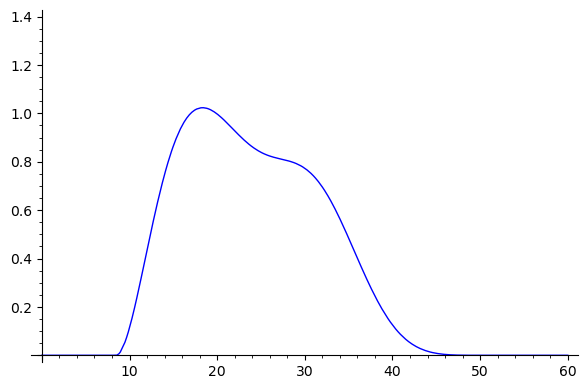

In [43]:
plot(lambda x, d1=disk_min, d2=disk_max: profile(x, d1, d2), 
     xmin=0, xmax=60, ymin=0, ymax=1.4)

In [44]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float R, G, B
    cdef float dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th
    R, G, B = 0., 0., 0. # return values
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:        
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonorma frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt
                # angle theta
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))
                # thickness
                R += 40*profile(r, dmin, dmax)/sin(abs(th)) # arbitrary factor
        x, y, z = x2, y2, z2
    # clipping
    if R >= 255:
        R = 255
    return R, G, B

In [45]:
def render_row(x):
    """
    Render a single row of the image
    """
    res = np.zeros((ny,3)) # result row in RGB format
    for y in range(ny):
        beta = atan2(y-ny/2,x)              # beta angle 
        r = sqrt(x**2+(y-ny/2)**2)          # pixel distance to the center of the image
        ind_geo = int(r/400*n_geod*720/nx)  # index of the geodesic to use. values are obtained by trial and error.
        if ind_geo<n_geod:                  # don't bother if the index is too big.
            res[ny-1-y,:] = intersection(geo[ind_geo], 2, float(Angle), float(beta), ###
                                         float(disk_min), float(disk_max))
    return x, res # also return the argument, which is not remembered otherwise

FloatProgress(value=0.0, max=720.0)

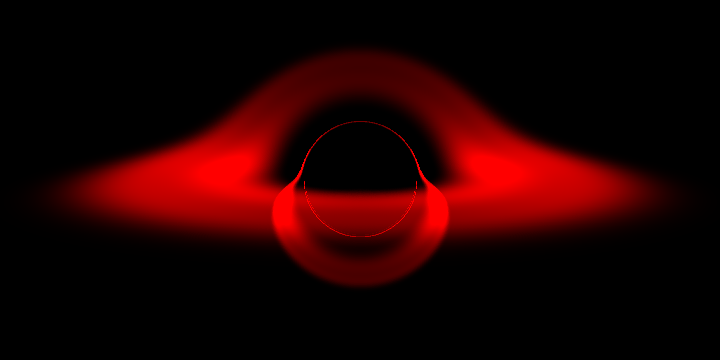

In [46]:
%display plain
data = np.zeros( (ny, nx, 3), dtype=float )
render()
img2 = toimage(data)
img2

In [47]:
from six.moves.urllib.request import urlretrieve  # valid for both Python 2 and Python 3
urlretrieve("http://www.cvrl.org/database/data/cmfs/ciexyzjv.csv", 
            "ciexyzjv.csv")
ciexyz = np.genfromtxt("ciexyzjv.csv", delimiter=",")

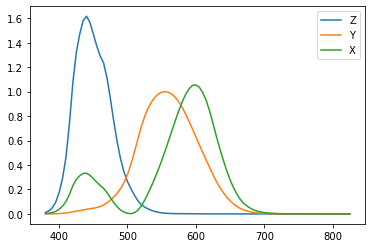

In [48]:
import matplotlib.pyplot as plt
plt.plot(ciexyz[:,0],ciexyz[:,3], label='Z')
plt.plot(ciexyz[:,0],ciexyz[:,2], label='Y')
plt.plot(ciexyz[:,0],ciexyz[:,1], label='X')
plt.legend(loc='best')
plt.show()

In [49]:
%%cython
from libc.math cimport exp

cpdef float blackbody(float nu, float T, float doppler):
    """
    Spectral power emmited at frequency nu by a black-body at 
    temperature T per square meter par steradian
    """
    cdef float h = 6.62e-34
    cdef float k = 1.38e-23
    cdef float c = 3e8
    cdef float h_sur_k = 4.79710144927536e-11
    return (2*h)*nu/c*nu/c*nu/(exp(h_sur_k*nu/doppler/T)-1)

verbose 0 (3835: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 171 points.
verbose 0 (3835: plot.py, generate_plot_points) Last error message: 'Unable to compute f(3000.0)'


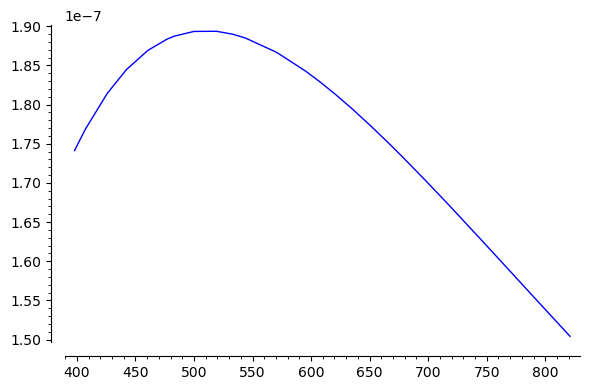

In [50]:
plot(spline([(l, blackbody(3e8/(l/1e9), 10000, 1)) for l in ciexyz[:,0]]), 
     xmin=5, xmax=3000)

In [51]:
%%cython
from __main__ import blackbody
from libc.math cimport exp
import numpy as np
cimport numpy as np
cimport cython

DTYPE = np.float
ctypedef np.float_t DTYPE_t

cdef np.float_t[:] cielamb
cdef np.float_t[:] ciex
cdef np.float_t[:] ciey
cdef np.float_t[:] ciez

def init_arrays():
    global cielamb, ciex, ciey, ciez
    cdef np.ndarray[np.float_t, ndim=2] ciexyz = np.genfromtxt('ciexyzjv.csv', delimiter=",")   
    cielamb = ciexyz[:, 0]
    ciex = ciexyz[:, 1]
    ciey = ciexyz[:, 2]
    ciez = ciexyz[:, 3]
    
init_arrays()

cpdef tuple temp_to_XYZ(float T, float doppler):
    cdef int nl = len(cielamb)
    cdef np.ndarray[np.float_t, ndim=1] sp = np.zeros(nl)
    cdef int i
    cdef float x, y, z
    for i in range(nl):
        sp[i] = blackbody(3e8/(cielamb[i]/1e9), T, doppler)
    x = np.dot(sp, ciex)
    y = np.dot(sp, ciey)
    z = np.dot(sp, ciez)
    return (x, y, z)

In [52]:
def xyz_to_rgb(*args):
    # constants
    fact = 3e-8 # arbitrary
    gamma = 1/2.2
    mat = [[3.24047, -1.53715, -0.498835],
           [-0.96256, 1.8752, 0.041556],
           [0.055648, -0.204043, 1.057311]]
    # conversion
    r, g, b = np.dot(mat, np.transpose(args)/fact).tolist()
    # gamma correction and clipping
    r = min(1,max(0, r)**gamma)
    g = min(1,max(0, g)**gamma)
    b = min(1,max(0, b)**gamma)
    return r, g, b

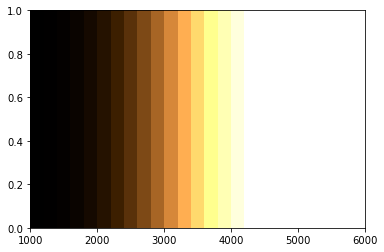

In [53]:
from matplotlib.patches import Rectangle
axes = plt.gca()
axes.set_xlim([1000, 6000])
for T in range(1000, 6000, 200):
    # plot a rectangle at a color obtained from the temperature
    axes.add_patch(Rectangle((T, 0), 200, 1, facecolor=xyz_to_rgb(*temp_to_XYZ(T, 1))))

In [54]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import temp_to_XYZ

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float X, Y, Z
    cdef float X0, Y0, Z0
    cdef float dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th, doppler, factor,
    X, Y, Z = 0., 0., 0. # return values
    # 20 percent speed gain
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    # rotations
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonormal frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt
                # angle theta
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))   
                # thickness
                factor = profile(r, dmin, dmax)/sin(abs(th))
                # unused for now
                doppler = 1
                # added luminosity
                X0, Y0, Z0 = temp_to_XYZ(8000, doppler) # T=8000 because I decided
                # updating XYZ
                X += X0*factor
                Y += Y0*factor
                Z += Z0*factor
        x, y, z = x2, y2, z2
    return X, Y, Z

In [55]:
data = np.zeros( (ny, nx, 3), dtype=float )
render()

FloatProgress(value=0.0, max=720.0)

In [56]:
%%cython

import numpy as np
cimport numpy as np

cpdef np.ndarray[np.int, ndim=3] XYZ_to_RGB(np.ndarray[double, ndim=3] data):
    """
    Convert an 2d-array of XYZ values to RGB using a simple formula
    """
    cdef int ny = len(data)
    cdef int nx = len(data[0])
    cdef float x, y, z
    cdef int r, g, b
    cdef int i, j
    cdef np.ndarray[int, ndim=3] res = np.zeros((ny, nx, 3), dtype = np.int32)
    cdef float fact = 3e-8
    cdef float gamma = 1/1.2
    for i in range(ny):
        for j in range(nx):
            x, y, z = data[i, j, :]
            #fact = max(.002*y,1e-7)
            x, y, z = x/fact, y/fact, z/fact
            r = int(max(0,(3.240479*x -1.537150*y -0.498535*z))**(gamma))
            g = int(max(0,(-0.969256*x  +1.875992*y  +0.041556*z))**(gamma))
            b = int(max(0,(0.055648*x -0.204043*y  +1.057311*z))**(gamma))
            r = min(255, max(0, r))
            g = min(255, max(0, g))
            b = min(255, max(0, b))
            res[i, j, :] = r, g ,b
    return res

In [57]:
data_rgb = XYZ_to_RGB(data)

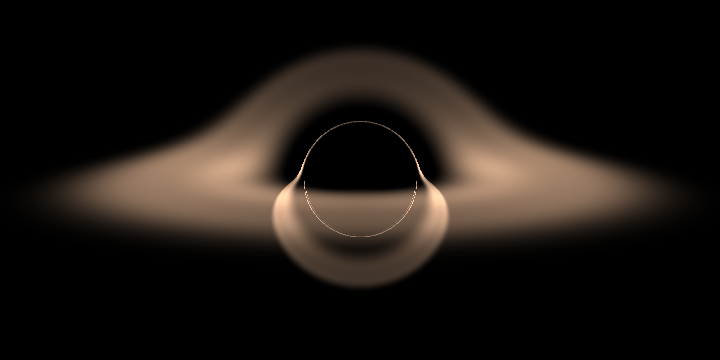

In [58]:
img3 = toimage(data_rgb)
img3

In [59]:
eqs = curve._equations_rhs[C]

In [60]:
dt, dr, dth, dph = curve._velocities

In [61]:
%display latex
# d^2t/dtau^2 = 
eqs[0].subs({th: pi/2, dr: 0, dth: 0})

0

In [62]:
# d^2r/dtau^2 = 
eqs[1].subs({th: pi/2, dr: 0, dth: 0})

-(Dph^2*a^6*m*r^2 - 4*Dph^2*a^4*m^2*r^3 - 4*Dph^2*a^2*m^2*r^5 + Dph^2*a^2*m*r^6 + 4*Dph^2*m*r^8 - Dph^2*r^9 - 2*Dph*Dt*a^5*m*r^2 + 8*Dph*Dt*a^3*m^2*r^3 + Dt^2*a^4*m*r^2 - 4*Dt^2*a^2*m^2*r^3 - 4*Dt^2*m^2*r^5 + Dt^2*m*r^6 + 2*(2*Dph^2*a^2 - Dph*Dt*a)*m*r^6 - 2*(Dph^2*a^2 + 2*Dph^2*m^2)*r^7 - (Dph^2*a^4 - 8*Dph*Dt*a*m^2)*r^5 + 2*(Dph^2*a^4*m + 2*Dph^2*a^2*m^3)*r^4 - 4*(Dph*Dt*a^3*m + 2*Dph*Dt*a*m^3)*r^4 + 2*(Dt^2*a^2*m + 2*Dt^2*m^3)*r^4)/(a^2*r^6 - 2*m*r^7 + r^8)

In [63]:
# d^2th/dtau^2 = 
eqs[2].subs({th: pi/2, dr: 0, dth: 0})

0

In [64]:
# d^2ph/dtau^2 = 
eqs[3].subs({th: pi/2, dr: 0, dth: 0})

0

In [65]:
eqs[1].subs({th: pi/2, dr: 0, dth: 0}).solve(dt)

[Dt == (Dph*a*m - sqrt(m*r)*Dph*r)/m, Dt == (Dph*a*m + sqrt(m*r)*Dph*r)/m]

In [66]:
p = M((0, r, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((r*sqrt(r/m)*dph, 0, 0, dph))

In [67]:
g.at(p)(v,v)

-4*Dph^2*a*m*sqrt(r/m) + Dph^2*(2*m - r)*r^2/m + (2*a^2*m + a^2*r + r^3)*Dph^2/r

In [68]:
(g.at(p)(v,v)==-1).solve(dph)

[Dph == -sqrt(m*r/(4*a*m^2*r*sqrt(r/m) - 2*a^2*m^2 - a^2*m*r - 3*m*r^3 + r^4)), Dph == sqrt(m*r/(4*a*m^2*r*sqrt(r/m) - 2*a^2*m^2 - a^2*m*r - 3*m*r^3 + r^4))]

In [69]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import temp_to_XYZ

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    """
    Return True if the curve intersect the disk comprised between dmin 
    and dmax tilted of angles alpha and beta
    """
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float X, Y, Z
    cdef float X0, Y0, Z0
    cdef float dt, dt0, dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th, rho, doppler, beta_rel
    X, Y, Z = 0., 0., 0. # return values
    # 20 percent speed gain
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    dt0 = curve[1][1]-curve[0][1]
    # rotations
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonormal frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt
                # angle theta (used for thickness)
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))
                # thickness
                factor = profile(r, dmin, dmax)/sin(abs(th))
                # angle rho (used for Doppler effect)
                rho = acos(dphi/sqrt(dr**2+dtheta**2+dphi**2))
                # beta (used for Doppler effect)
                beta_rel = sqrt(m/(r-3*m))
                # Doppler factor
                doppler = 1
                doppler *= dt0/dt        # gravitational redshift
                doppler *= 1/(sqrt(1-beta_rel**2)*(1+beta_rel*cos(rho))) # rotation of the disk
                # added luminosity
                X0, Y0, Z0 = temp_to_XYZ(8000, doppler) # T=8000 because I decided
                # updating XYZ
                X += X0*factor
                Y += Y0*factor
                Z += Z0*factor
        x, y, z = x2, y2, z2
    return X, Y, Z

FloatProgress(value=0.0, max=720.0)

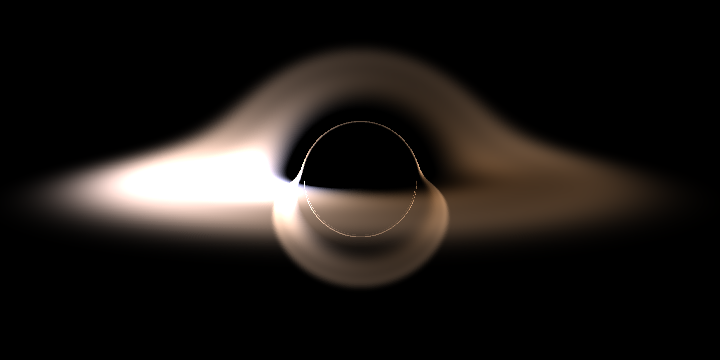

In [70]:
%display plain
data = np.zeros( (ny, nx, 3), dtype=float )
render()
data_rgb = XYZ_to_RGB(data)
img4 = toimage(data_rgb)
img4

In [71]:
beta = var('beta')

In [72]:
thp = acos((cos(th)-beta)/(1-beta*cos(th)))

In [73]:
%display latex
diff(thp,th)

-((beta - cos(th))*beta*sin(th)/(beta*cos(th) - 1)^2 + sin(th)/(beta*cos(th) - 1))/sqrt(-(beta - cos(th))^2/(beta*cos(th) - 1)^2 + 1)

In [74]:
aberration = abs(diff(thp,th)) # abs needed if we want negative angles

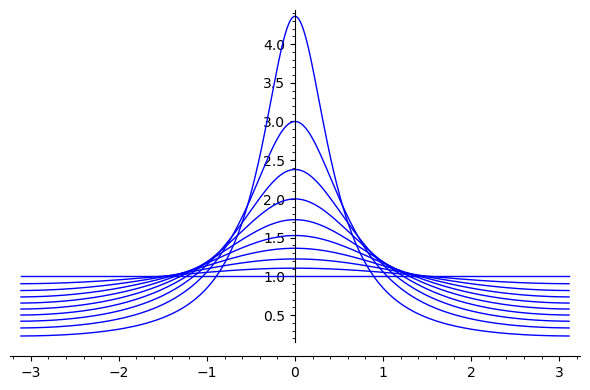

In [75]:
P = plot(aberration.subs(beta=0.), [-pi*.99,pi*.99])
for i in range(1,10):
    P += plot(aberration.subs({beta: 0.1*i}), [-pi*.99,pi*.99])
P.plot()

In [76]:
%%cython
from libc.math cimport cos, sin ,sqrt

cpdef float focalisation_factor(float th, float beta):
    # uses an other expression stricly equal, but faster to compute.
    return (cos(th)*(cos(th)+beta)+sin(th)**2)/\
        (sin(th)**2*sqrt(1-beta**2)+1/sqrt(1-beta**2)*(beta+cos(th))**2)

In [77]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import temp_to_XYZ
from __main__ import focalisation_factor

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef tuple intersection(list curve, float m, float alpha, float beta, 
                         float dmin, float dmax):
    cdef float x, y, z
    cdef float x2, y2, z2
    cdef float r, theta, phi
    cdef int n, i
    cdef float t
    cdef float sinalpha, cosalpha
    cdef float sinbeta, cosbeta
    cdef float X, Y, Z
    cdef float X0, Y0, Z0
    cdef float dt, dt0, dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float th, rho, doppler, beta_rel
    X, Y, Z = 0., 0., 0. # return values
    # 20 percent speed gain
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    dt0 = curve[1][1]-curve[0][1]
    # rotations
    x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
    x, y, z = x, y*cos(beta)-z*sin(beta), z*cos(beta)+y*sin(beta)
    z = z*cos(alpha)+x*sin(alpha)
    for i in range(1, n):        
        r = curve[i][2]
        theta = curve[i][3]
        phi = curve[i][4]
        # rotations
        x2, y2, z2 = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
        y2, z2 = y2*cosbeta-z2*sinbeta, z2*cosbeta+y2*sinbeta
        x2, z2 = x2*cosalpha-z2*sinalpha, z2*cosalpha+x2*sinalpha
        if z!=z2:
            t = z/(z-z2)
            if t>=0 and t<1 and curve[i][2]>dmin and curve[i][2]<dmax:
                # 4-velocity
                dt = curve[i+1][1]-curve[i][1]
                dr = curve[i+1][2]-curve[i][2]
                dtheta = curve[i+1][3]-curve[i][3]
                dphi = curve[i+1][4]-curve[i][4]          
                # rotation of the 4-velocity
                dx, dy, dz = spherical_to_xyz(dr, dtheta, dphi, r, theta, phi, 
                                              alpha, beta)
                dr, dtheta, dphi = xyz_to_spherical(dx, dy, dz, x2, y2, z2)
                # change of frame to orthonormal frame:
                dr = 2*m/(sqrt(r*(2*m+r)))*dt+sqrt((2*m+r)/r)*dr
                dtheta = dtheta*r
                dphi = dphi*r # theta = pi/2
                dt = sqrt(r/(2*m+r))*dt          
                # angle theta (used for thickness)
                th = atan2(dtheta, (sqrt(dr**2+dphi**2)))
                # thickness
                factor = profile(r, dmin, dmax)/sin(abs(th))
                # angle rho (used for Doppler effect)
                rho = acos(dphi/sqrt(dr**2+dtheta**2+dphi**2))
                # beta (used for Doppler effect and focalisation)
                beta_rel = sqrt(m/(r-3*m))
                # Doppler factor
                doppler = 1
                doppler *= dt0/dt        # gravitational redshift
                doppler *= 1/(sqrt(1-beta_rel**2)*(1+beta_rel*cos(rho))) # rotation of the disk
                # added luminosity
                X0, Y0, Z0 = temp_to_XYZ(8000, doppler) # T=8000 because I decided
                # focalisation
                factor *= focalisation_factor(rho, beta_rel)
                # updating XYZ
                X += X0*factor
                Y += Y0*factor
                Z += Z0*factor
        x, y, z = x2, y2, z2
    return X, Y, Z

FloatProgress(value=0.0, max=720.0)

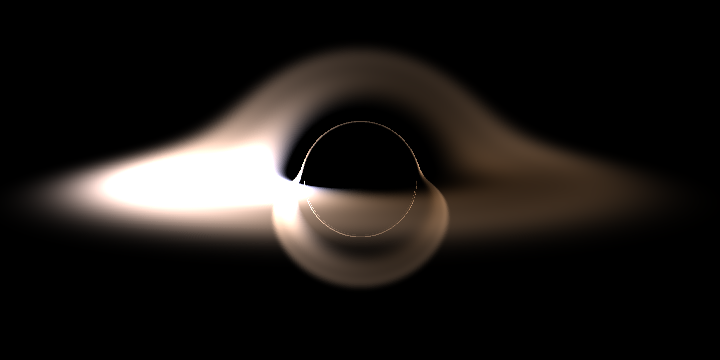

In [78]:
%display plain
data = np.zeros( (ny, nx, 3), dtype=float )
render()
data_rgb = XYZ_to_RGB(data)
img5 = toimage(data_rgb)
# img5.save("my_home_made_black_hole.png") # uncomment to save
img5

## Summary

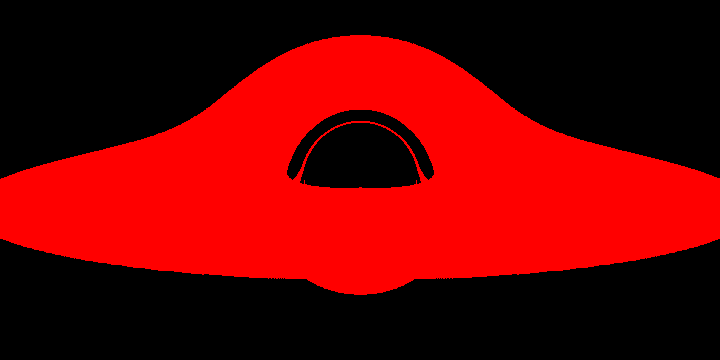

In [79]:
img1

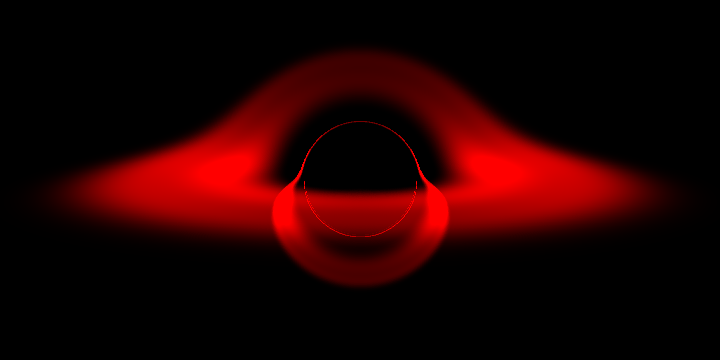

In [80]:
img2

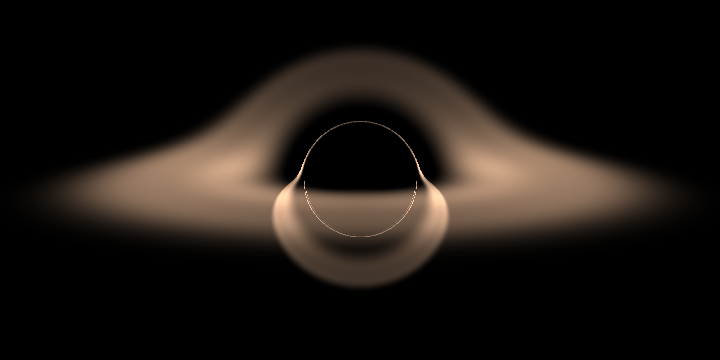

In [81]:
img3

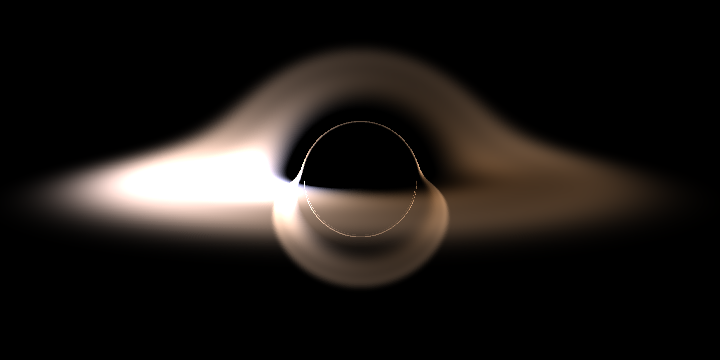

In [82]:
img4

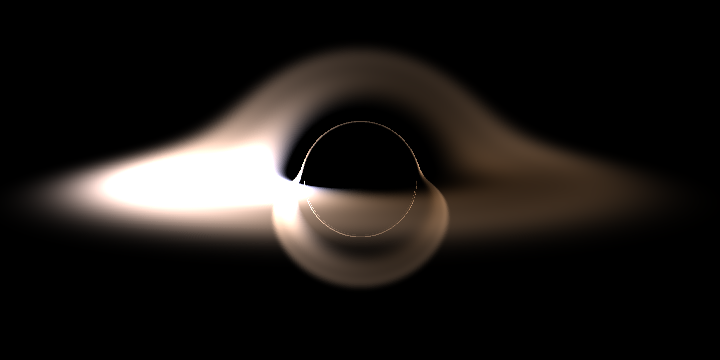

In [83]:
img5

In [84]:
# img1.save("pi2/a_19/img1.png")
# img2.save("pi2/a_19/img2.png")
# img3.save("pi2/a_19/img3.png")
# img4.save("pi2/a_19/img4.png")
# img5.save("pi2/a_19/img5.png")